<a href="https://colab.research.google.com/github/benjipeng/ML-open/blob/main/Contrastive_Learning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning

## Work with the `CIFAR-10` dataset

`CIFAR-10` is a widely used dataset in machine learning and computer vision for benchmarking image classification algorithms. It consists of `60,000` `32x32` color images in `10` different classes, with 6,000 images per class. The dataset is divided into `50,000` training images and `10,000` test images.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
transform = transforms.ToTensor()

In [4]:
train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:06<00:00, 28280570.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Define class names
classes = train_dataset.classes
print("Classes in CIFAR-10:", classes)

Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 50000
Number of test samples: 10000


In [11]:
# Access the first sample
image, label = train_dataset[0]
print("Image shape:", image.shape)
print("Label:", label)
print("Class name:", classes[label])

Image shape: torch.Size([3, 32, 32])
Label: 6
Class name: frog


In [13]:
# Iterate over the first 5 samples
for i in range(5):
    img, label = train_dataset[i]
    print(f"Sample {i}: Label={label}, Class={classes[label]}")

Sample 0: Label=6, Class=frog
Sample 1: Label=9, Class=truck
Sample 2: Label=9, Class=truck
Sample 3: Label=4, Class=deer
Sample 4: Label=1, Class=automobile


In [14]:
# Access the first image and label
image, label = train_dataset[0]

# Convert the tensor to a NumPy array
np_image = image.numpy()
print("NumPy image shape:", np_image.shape)

NumPy image shape: (3, 32, 32)


In [15]:
import matplotlib.pyplot as plt

def imshow(img, title=None):
    """
    Display a tensor as an image.

    Args:
        img (Tensor): Image tensor of shape [C, H, W]
        title (str, optional): Title of the image
    """
    img = img.numpy()                # Convert to NumPy array
    img = np.transpose(img, (1, 2, 0))  # Convert to [H, W, C]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')                  # Hide axis
    plt.show()

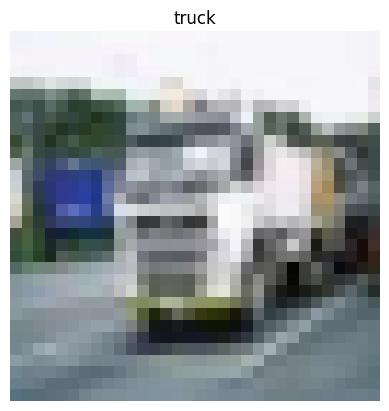

In [18]:
# Get the first image and its label
image, label = train_dataset[1000]

# Show the image
imshow(image, title=classes[label])

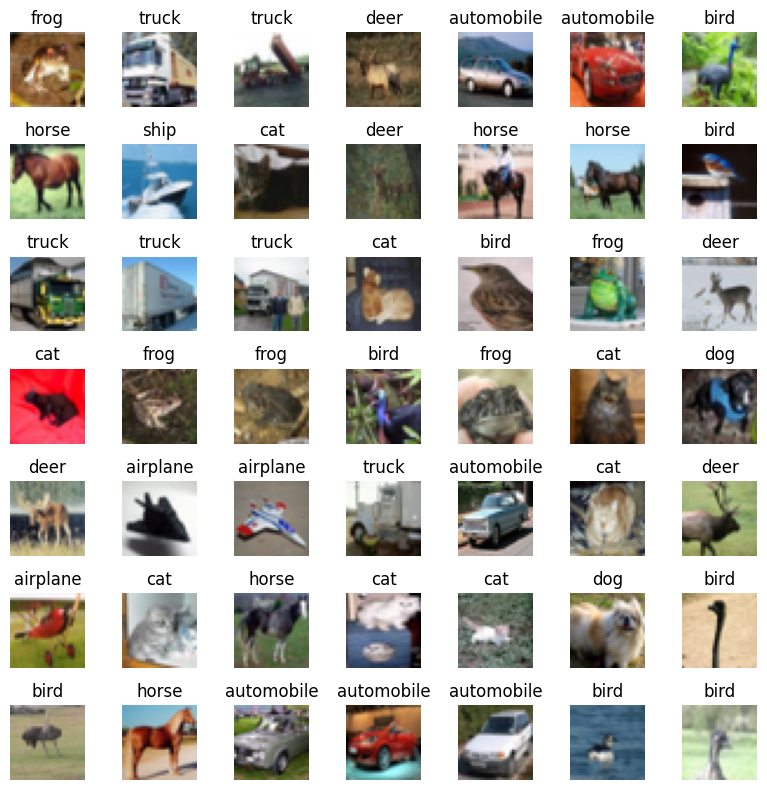

In [21]:
def show_images_grid(dataset, num_images=16):
    """
    Display a grid of images from the dataset.

    Args:
        dataset (Dataset): PyTorch dataset
        num_images (int): Number of images to display
    """
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i+1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a 3x3 grid of images
show_images_grid(train_dataset, num_images=49)

In [22]:
from torch.utils.data import DataLoader


In [23]:
# Define batch size
batch_size = 4

# Create DataLoader for training set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,           # Shuffle data at every epoch
    num_workers=2           # Number of subprocesses for data loading
)

# Create DataLoader for test set
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,          # No need to shuffle test data
    num_workers=2
)


In [25]:
# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Batch image shape:", images.shape)  # Should be [batch_size, 3, 32, 32]
print("Batch labels:", labels)


Batch image shape: torch.Size([4, 3, 32, 32])
Batch labels: tensor([2, 6, 5, 4])


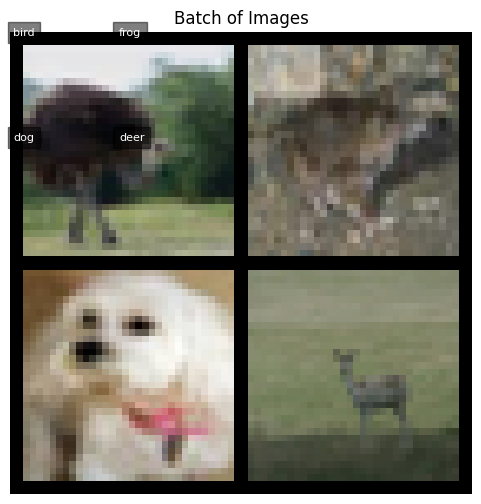

In [26]:
def show_batch(images, labels, classes, batch_size=4):
    """
    Display a batch of images.

    Args:
        images (Tensor): Batch of images [B, C, H, W]
        labels (Tensor): Batch of labels [B]
        classes (list): List of class names
        batch_size (int): Number of images in the batch
    """
    # Make a grid of images
    grid = torchvision.utils.make_grid(images, nrow=2)

    # Convert the tensor to NumPy for plotting
    np_grid = grid.numpy()
    np_grid = np.transpose(np_grid, (1, 2, 0))

    plt.figure(figsize=(6, 6))
    plt.imshow(np_grid)
    plt.title('Batch of Images')
    plt.axis('off')

    # Add labels
    for i in range(batch_size):
        plt.text(
            (i % 2) * 16, (i // 2) * 16,
            classes[labels[i]],
            fontsize=8,
            color='white',
            bbox=dict(facecolor='black', alpha=0.5)
        )
    plt.show()

# Visualize the batch
show_batch(images, labels, classes, batch_size=batch_size)


In [27]:
# Define transformations for training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),          # Randomly flip image horizontally
    transforms.RandomCrop(32, padding=4),       # Randomly crop with padding
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Normalize with mean and std
                         (0.2023, 0.1994, 0.2010))
])

# Define transformations for test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Reload the datasets with the new transformations
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Re-create DataLoaders with the updated datasets
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


Files already downloaded and verified
Files already downloaded and verified


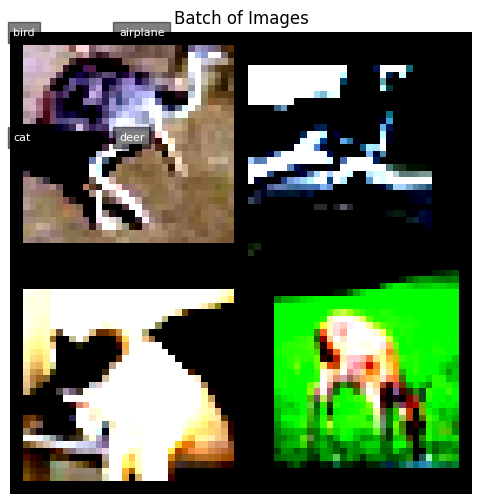

In [29]:
# Get one batch of training data with transformations
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the batch
show_batch(images, labels, classes, batch_size=batch_size)


### Work with CIFAR100

In [35]:
transform = transforms.ToTensor()

In [36]:
train_dataset_100 = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform = transform
)

100%|██████████| 169001437/169001437 [00:03<00:00, 54956104.73it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [43]:
len(train_dataset[0])

2

In [54]:
img_tensor, label = (train_dataset_100[1])

In [55]:
label = train_dataset_100.classes[label]

(-0.5, 31.5, 31.5, -0.5)

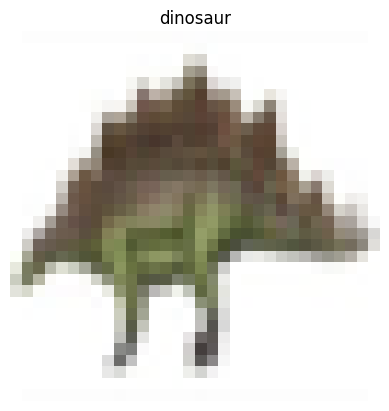

In [56]:
plt.imshow(img_tensor.numpy().transpose(1,2,0))
plt.title(label)
plt.axis('off')

## What is Contrastive Learning?

`Contrastive Learning` is a type of **self-supervised learning** where the model learns to **differentiate** between similar (positive) and dissimilar (negative) pairs of data. The primary objective is to learn representations where similar samples are ***close*** in the embedding space, and dissimilar ones are far ***apart***.

### InfoNCE
NCE stands for Noise-Contrastive Estimation

Given a batch of N samples, for each sample, there is one positive and 2N-2 negatives (all other samples in the batch).

$$\mathcal{L} = -\log \frac{\exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_j)/\tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_k)/\tau)}$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR

In [3]:
class Config:
    # Data parameters
    batch_size = 512  # Increased batch size for better negatives
    image_size = 96  # Higher resolution
    num_workers = 4

    # Model parameters
    embedding_dim = 128
    projection_dim = 128  # Dimension of the projection head
    temperature = 0.5

    # Training parameters
    epochs = 200
    learning_rate = 1e-3
    weight_decay = 1e-6
    scheduler_step_size = 60
    scheduler_gamma = 0.1

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model saving
    model_path = './contrastive_model_improved.pth'

config = Config()


In [4]:
# Updated data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(config.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=int(0.1 * config.image_size)),
    transforms.ToTensor(),
])

# Original transform for visualization
original_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
])


In [19]:
class ContrastiveSTL10(Dataset):
    def __init__(self, root, split='train', transform=None, download=True):
        self.dataset = torchvision.datasets.STL10(root=root, split=split,
                                                 transform=None,
                                                 download=download)
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        # Generate two augmented views
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)


# Initialize datasets and dataloaders
train_dataset = ContrastiveSTL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, drop_last=True)

# For visualization
test_dataset = torchvision.datasets.STL10(root='./data', split='test', transform=original_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=config.num_workers)


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [11]:
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128, projection_dim=128):
        super(ResNetEncoder, self).__init__()
        # Use ResNet-18 backbone
        self.backbone = resnet18(pretrained=False, num_classes=embedding_dim)
        self.backbone.fc = nn.Identity()  # Remove the classification layer

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, embedding_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = F.normalize(x, dim=1)
        x = self.projection(x)
        x = F.normalize(x, dim=1)
        return x


In [12]:
class SimCLRContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, z1, z2):
        batch_size = z1.size(0)
        z = torch.cat([z1, z2], dim=0)  # [2B, D]
        sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2B, 2B]

        # Create labels
        labels = torch.arange(batch_size).to(config.device)
        labels = torch.cat([labels, labels], dim=0)

        # Mask to remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(config.device)
        sim_matrix = sim_matrix.masked_fill(mask, -9e15)

        # Compute similarity scores
        positives = torch.cat([torch.diag(sim_matrix, batch_size),
                               torch.diag(sim_matrix, -batch_size)], dim=0)
        negatives = sim_matrix

        # Concatenate positives and negatives
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        labels = torch.zeros(2 * batch_size, dtype=torch.long).to(config.device)

        # Scale by temperature
        logits = logits / self.temperature

        loss = F.cross_entropy(logits, labels)
        return loss


In [13]:
# Initialize encoder, loss function, optimizer, and scheduler
encoder = ResNetEncoder(embedding_dim=config.embedding_dim, projection_dim=config.projection_dim).to(config.device)
criterion = SimCLRContrastiveLoss(temperature=config.temperature)
optimizer = optim.Adam(encoder.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
def train_improved(encoder, loader, optimizer, criterion, scheduler, epoch):
    encoder.train()
    total_loss = 0
    for batch_idx, (img1, img2) in enumerate(loader):
        img1 = img1.to(config.device)
        img2 = img2.to(config.device)

        optimizer.zero_grad()

        # Get embeddings
        z1 = encoder(img1)
        z2 = encoder(img2)

        # Compute contrastive loss
        loss = criterion(z1, z2)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch}/{config.epochs}] Batch [{batch_idx}/{len(loader)}] Loss: {loss.item():.4f}")

    scheduler.step()
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")


In [16]:
def save_model_improved(encoder, path=config.model_path):
    torch.save(encoder.state_dict(), path)
    print(f"Model saved to {path}")

def load_model_improved(encoder, path=config.model_path):
    if os.path.exists(path):
        encoder.load_state_dict(torch.load(path))
        encoder.to(config.device)
        print(f"Model loaded from {path}")
    else:
        print(f"No model found at {path}")


In [17]:
def visualize_embeddings_improved(encoder, loader):
    encoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for img, target in loader:
            img = img.to(config.device)
            z = encoder.backbone(img)  # Use backbone for better embeddings
            embeddings.append(z.cpu().numpy())
            labels.append(target.numpy())
            if len(embeddings) * config.batch_size >= 2000:
                break
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings[:2000])  # Limit for speed

    plt.figure(figsize=(12, 12))
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels[:2000], cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization of Enhanced Embeddings")
    plt.show()


In [20]:
# Optionally load existing model
# load_model_improved(encoder)

for epoch in range(1, config.epochs + 1):
    train_improved(encoder, train_loader, optimizer, criterion, scheduler, epoch)

    # Save the model every 20 epochs
    if epoch % 20 == 0:
        save_model_improved(encoder)

    # Visualize embeddings every 40 epochs
    if epoch % 40 == 0:
        visualize_embeddings_improved(encoder, test_loader)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x512 and 128x128)